In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from ast import literal_eval
from sklearn.metrics import auc
import numpy as np

In [2]:
controller_output = Path('output')

In [3]:
low_df = pd.read_csv(controller_output / '100_runs_lowest_utility.csv')
high_df = pd.read_csv(controller_output / '100_runs_highest_utility.csv')
random_df = pd.read_csv(controller_output / '100_runs_random_utility.csv')

In [4]:
for df in [low_df, high_df, random_df]:
    df.loc[~df['predicted_optimal_utility'].isna(), 'rule_costs'] = df.loc[~df['predicted_optimal_utility'].isna(), 'rule_costs'].apply(literal_eval)

## Rule Picking Strategies (for choosing action per issue)

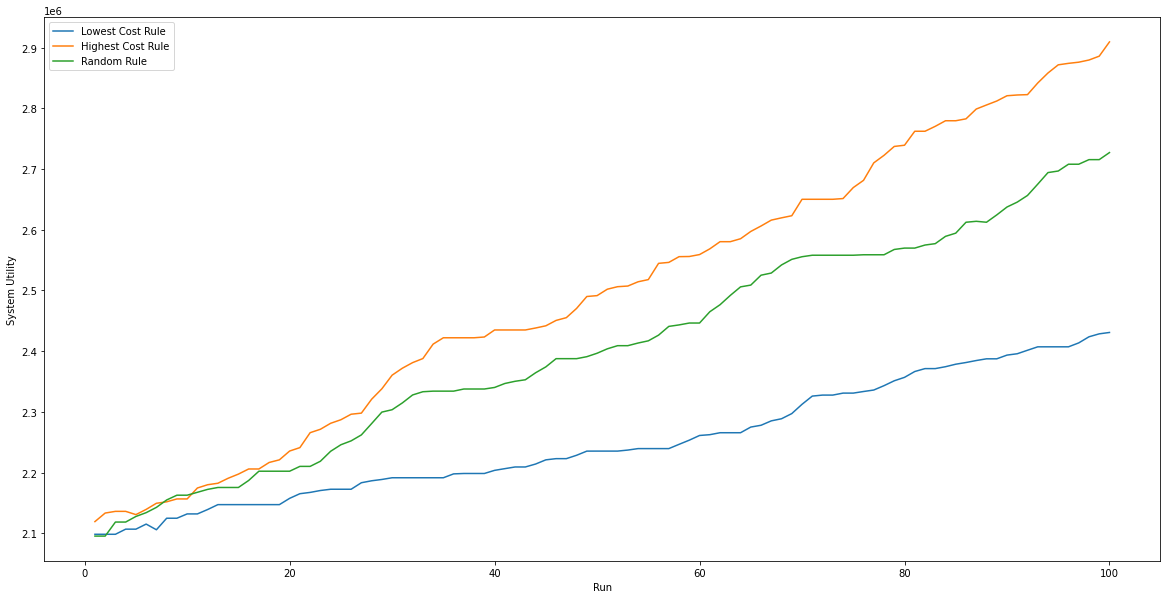

In [5]:
fig, ax = plt.subplots(figsize=(20,10))
sns.lineplot(x='run', y='system_utility', data=low_df, ax=ax, ci=None, label='Lowest Cost Rule')
sns.lineplot(x='run', y='system_utility', data=high_df, ax=ax, ci=None, label='Highest Cost Rule')
sns.lineplot(x='run', y='system_utility', data=random_df, ax=ax, ci=None, label='Random Rule')
ax.set(xlabel='Run', ylabel='System Utility');

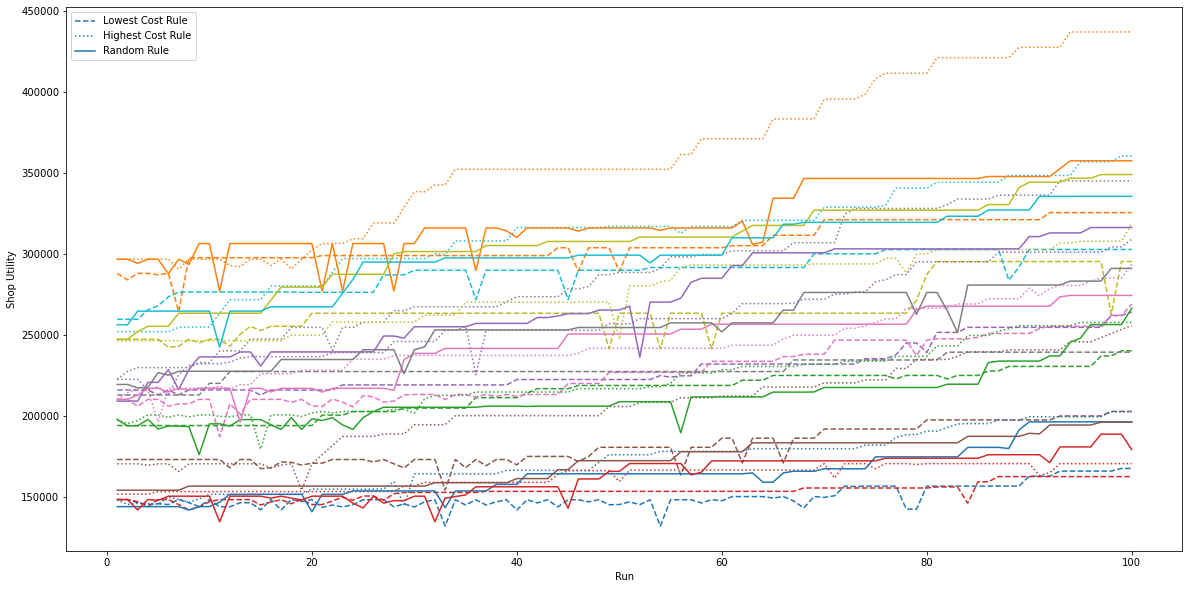

In [6]:
fig, ax = plt.subplots(figsize=(20,10))
lowest = sns.lineplot(x='run', y='shop_utility', hue='shop', data=low_df, ci=None, linestyle='dashed', ax=ax, label='Lowest Cost Rule', legend=False)
highest = sns.lineplot(x='run', y='shop_utility', hue='shop', data=high_df, ci=None, linestyle='dotted', ax=ax, label='Highest Cost Rule', legend=False)
random = sns.lineplot(x='run', y='shop_utility', hue='shop', data=random_df, ci=None, ax=ax, label='Random Rule', legend=False)
ax.set(xlabel='Run', ylabel='Shop Utility');
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::10], ['Lowest Cost Rule', 'Highest Cost Rule', 'Random Rule']);

## Issue Ranking Strategies

In [7]:
low_u_df = pd.read_csv(controller_output / '100_runs_lowest_utility.csv')
low_c_df = pd.read_csv(controller_output / '100_runs_lowest_cost.csv')
low_r_df = pd.read_csv(controller_output / '100_runs_lowest_random.csv')


In [8]:
for df in [low_u_df, low_c_df, low_r_df]:
    df['combined_index'] = 'after fixing ' + df['failure_name'].astype(str) + ' (' + df['shop'].astype(str) + ')'

In [9]:
def get_interesting_rows_from_run(df:pd.DataFrame, run_to_show:int=1):
    example = df.query('run == @run_to_show')
    number_of_faults = example['predicted_optimal_utility'].notna().sum()
    example_fixes = example.sort_values(['fix_status', 'predicted_optimal_utility'], ascending=False)\
                           .loc[(example['combined_index'].str.contains('CF')) | (example['fix_status'] == 'after')]\
                           .iloc[:number_of_faults, :]
    example_fixes['estimated_system_utility'] = example_fixes['system_utility'] + example_fixes['predicted_optimal_utility'].fillna(0).cumsum()
    example_fixes['auc'] = auc(x=np.arange(len(example_fixes)), y=example_fixes['estimated_system_utility'].values)
    return example_fixes


In [10]:
low_u_ex = get_interesting_rows_from_run(low_u_df, 7)

In [11]:
low_u_ex.plot(
        x='combined_index',
        y='estimated_system_utility',
        drawstyle='steps-post',
        rot=90,
        ax=ax
    )

<AxesSubplot:xlabel='combined_index', ylabel='Shop Utility'>